In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from datetime import date, datetime, timedelta

from etl.load_volatility import get_data_with_vix


sns.set_style("darkgrid")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


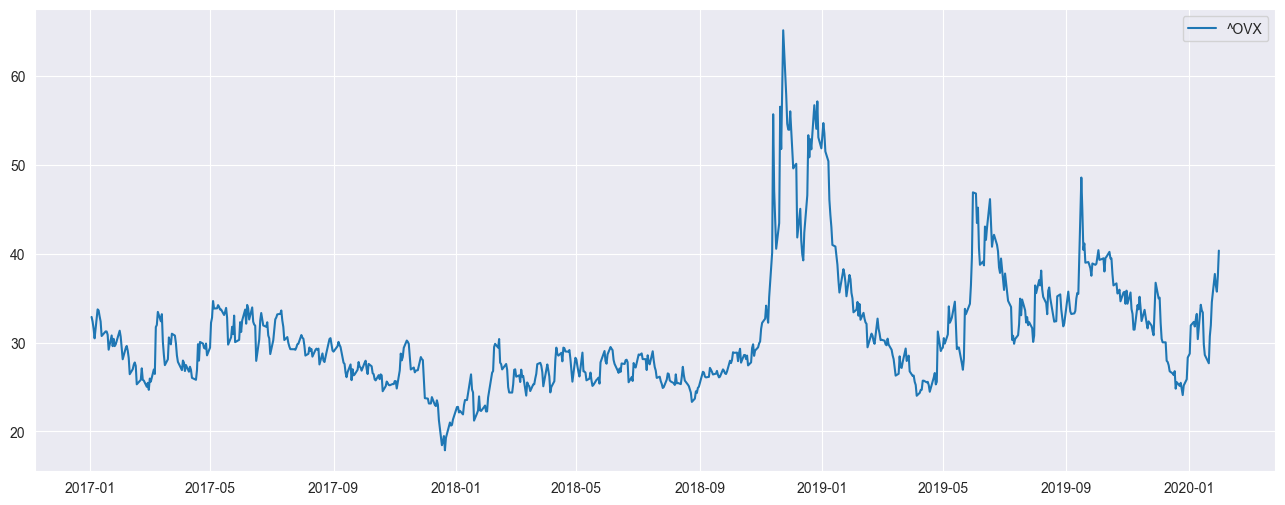

In [3]:
ticker = "CL=F"
vix = "^OVX"
interval = "1d"

# NOTE: covid should be excluded.

# Pre-covid
start_date = datetime.strptime("2017-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2020-02-01", "%Y-%m-%d")


# Post-covid
# start_date = datetime.strptime("2020-11-01", "%Y-%m-%d")
# end_date = date.today()

df = get_data_with_vix(ticker=ticker, vix=vix, start_date=start_date, end_date=end_date, interval=interval)


fig = plt.figure()
fig.set_size_inches(16, 6)

plt.plot(df["vix"], label=vix)
plt.legend()
plt.show()

In [4]:
from algo.models.sde.ornstein_uhlenbeck_model import OrnsteinUhlenbeck
from algo.models.sde.ornstein_uhlenbeck_model_optimisation import OptimiserOU

In [5]:
A = 1.0
# dt = 1/252
dt = 1
x = df["vix"]

optimiser = OptimiserOU(A=A, dt=dt)
ou_params = optimiser.model_params_ou(x)
ou_params

ModelParamsOU(theta=31.015338663246187, mu=0.03994916164121459, sigma_sq=3.568254252137785, log_likelihood=-2.0162808789049187, B=None)

In [6]:
ou_model = OrnsteinUhlenbeck(X_0=x[0], theta=ou_params.theta, k=ou_params.mu, sigma=ou_params.sigma)
ou_process_simulated = ou_model(num_samples=len(x))

df["vix_sim"] = ou_process_simulated

In [7]:
def sim_results(ou_params, ou_params_sim):
    # Want these differences to be as small as possible
    df_summary = pd.DataFrame(columns=["Real Data", "Sim", "% Diff"])
    df_summary["Real Data"] = [ou_params.theta, ou_params.mu, ou_params.sigma, ou_params.log_likelihood]
    df_summary["Sim"] = [ou_params_sim.theta, ou_params_sim.mu, ou_params_sim.sigma, ou_params_sim.log_likelihood]
    df_summary["% Diff"] = 100.0 * (df_summary["Real Data"] - df_summary["Sim"]) / df_summary["Real Data"]
    df_summary.index = ["theta", "mu", "sigma", "log_li"]
    
    return df_summary


ou_params_sim = optimiser.model_params_ou(ou_process_simulated)
df_summary = sim_results(ou_params, ou_params_sim)
df_summary.round(3)

,Real Data,Sim,% Diff
theta,31.015,27.856,10.185
mu,0.040,0.033,17.940
sigma,1.889,1.845,2.340
log_li,-2.016,-2.015,0.072


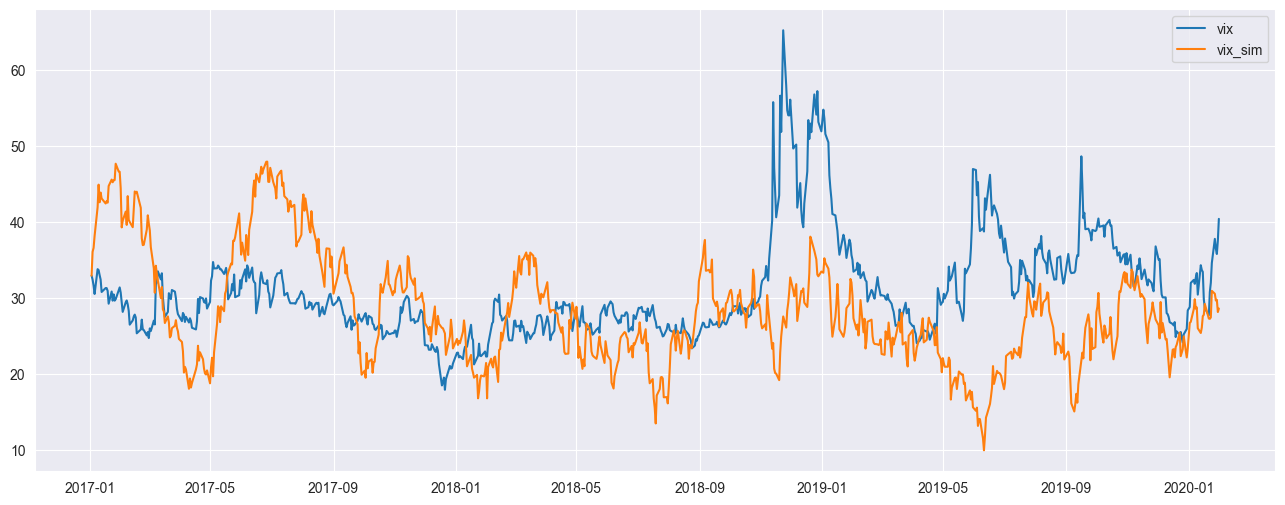

In [8]:
fig = plt.figure()
fig.set_size_inches(16, 6)

plt.plot(df["vix"], label="vix")
plt.plot(df["vix_sim"], label="vix_sim")
plt.legend()
plt.show()

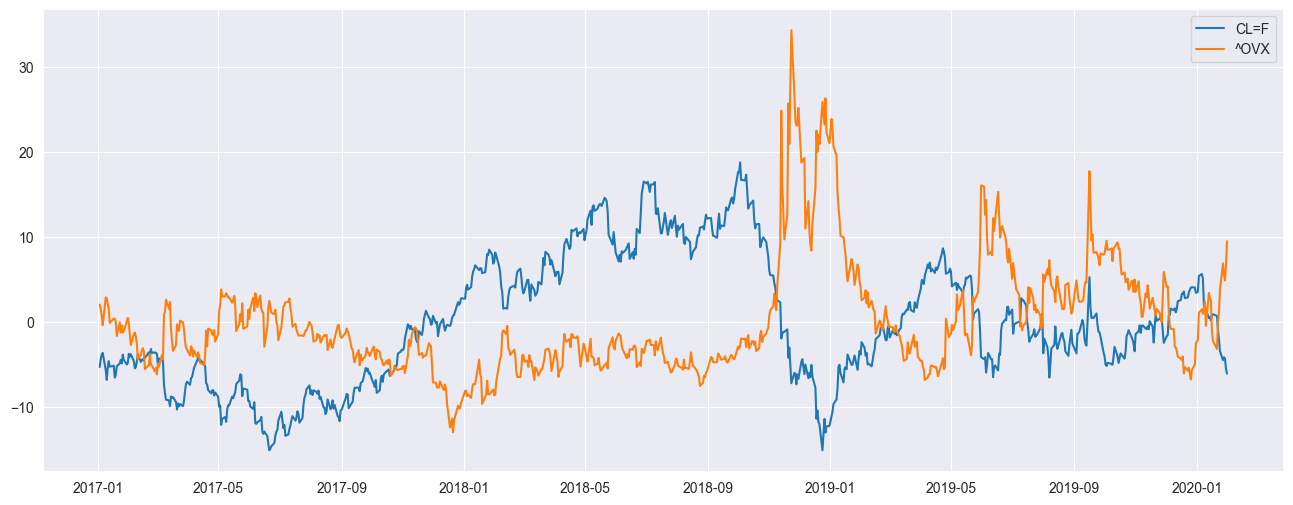

In [34]:
fig = plt.figure()
fig.set_size_inches(16, 6)

plt.plot(df["price"] - df["price"].mean(), label=ticker)
plt.plot(df["vix"] - df["vix"].mean(), label=vix)
plt.legend()
plt.show()